# Pipeline Machine Learning Complet - Prévision météo (série temporelle)

## Contexte
Ce notebook implémente un pipeline complet de Machine Learning, de la collecte de données jusqu’au déploiement, en respectant les phases demandées (collecte, préparation, features, stockage SQLite, archivage, EDA, entraînement, validation, API, monitoring).

## Problématique (série temporelle)
Prédire la **température horaire** à l’horizon **t + 1 heure** à partir des observations passées.


# Étape 1 - Choix du sujet (dataset)

## Sujet 
**Prévision de la température horaire** (régression) : prédire `temperature_2m(t+1)` à partir des observations à `t, t-1, t-2, ...`

## Source de données
**Open-Meteo Historical Weather API**
- Données publiques
- Accès gratuit
- Sans clé API
- Historique horaire

## Objectif de prédiction
- Variable cible : `temperature_2m`
- Horizon : `t+1` (une heure après)


In [14]:
# ============================
# Imports (base)
# ============================

from pathlib import Path
from datetime import datetime, timedelta, timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

print("✅ Imports OK")


✅ Imports OK


# Phase 0-— Initialisation & configuration

## Objectifs
- Créer l’arborescence du projet
- Définir les chemins de travail
- Centraliser les paramètres (ville, période, variables, etc.)

## Arborescence attendue
- `data/raw/`
- `data/processed/`
- `data/archive/`
- `models/`
- `reports/`


In [15]:
# Phase 0 — Arborescence

PROJECT_ROOT = Path(".").resolve()

DIR_DATA = PROJECT_ROOT / "data"
DIR_RAW = DIR_DATA / "raw"
DIR_PROCESSED = DIR_DATA / "processed"
DIR_ARCHIVE = DIR_DATA / "archive"
DIR_MODELS = PROJECT_ROOT / "models"
DIR_REPORTS = PROJECT_ROOT / "reports"

for d in [DIR_RAW, DIR_PROCESSED, DIR_ARCHIVE, DIR_MODELS, DIR_REPORTS]:
    d.mkdir(parents=True, exist_ok=True)

print("✅ Dossiers créés / vérifiés :")
print(" -", DIR_RAW)
print(" -", DIR_PROCESSED)
print(" -", DIR_ARCHIVE)
print(" -", DIR_MODELS)
print(" -", DIR_REPORTS)


✅ Dossiers créés / vérifiés :
 - C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\raw
 - C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\processed
 - C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\archive
 - C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\models
 - C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\reports


In [16]:
# Phase 0 — Configuration

CONFIG = {
    "source_name": "open_meteo_historical",
    "timezone": "Europe/Paris",

    # Localisation (modifiable)
    "city": "Paris",
    "latitude": 48.8566,
    "longitude": 2.3522,

    # Historique
    "history_days": 90,

    # Variables horaires à récupérer
    "hourly_vars": [
        "temperature_2m",
        "relative_humidity_2m",
        "precipitation",
        "pressure_msl",
        "wind_speed_10m",
        "cloud_cover",
    ],

    # Objectif ML
    "target_col": "temperature_2m",
    "horizon_steps": 1,  # t+1 (1 heure)

    # Base SQLite
    "db_path": str(DIR_DATA / "pipeline.db"),
}

end_date = datetime.now(timezone.utc).date()
start_date = (datetime.now(timezone.utc) - timedelta(days=CONFIG["history_days"])).date()
CONFIG["start_date"] = str(start_date)
CONFIG["end_date"] = str(end_date)

print("✅ CONFIG prête :")
for k, v in CONFIG.items():
    print(f" - {k}: {v}")


✅ CONFIG prête :
 - source_name: open_meteo_historical
 - timezone: Europe/Paris
 - city: Paris
 - latitude: 48.8566
 - longitude: 2.3522
 - history_days: 90
 - hourly_vars: ['temperature_2m', 'relative_humidity_2m', 'precipitation', 'pressure_msl', 'wind_speed_10m', 'cloud_cover']
 - target_col: temperature_2m
 - horizon_steps: 1
 - db_path: C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\pipeline.db
 - start_date: 2025-10-28
 - end_date: 2026-01-26


# Phase 1 - Collecte et ingestion des données

## Objectifs
- Utiliser une **source publique** : Open-Meteo (API)
- Récupérer automatiquement une période suffisante (**90 jours** par défaut)
- Sauvegarder les données brutes dans `data/raw/` au format **JSON + CSV** avec **horodatage**
- Afficher un aperçu : `head()`, dimensions, types


In [17]:
# Phase 1 — 1) Requête API

import requests

BASE_URL = "https://archive-api.open-meteo.com/v1/archive"

params = {
    "latitude": CONFIG["latitude"],
    "longitude": CONFIG["longitude"],
    "start_date": CONFIG["start_date"],
    "end_date": CONFIG["end_date"],
    "hourly": ",".join(CONFIG["hourly_vars"]),
    "timezone": CONFIG["timezone"],
}

print("- Source publique :", CONFIG["source_name"])
print("- Ville :", CONFIG["city"], "|", CONFIG["latitude"], CONFIG["longitude"])
print("- Période :", CONFIG["start_date"], "→", CONFIG["end_date"])
print("- Variables :", CONFIG["hourly_vars"])


- Source publique : open_meteo_historical
- Ville : Paris | 48.8566 2.3522
- Période : 2025-10-28 → 2026-01-26
- Variables : ['temperature_2m', 'relative_humidity_2m', 'precipitation', 'pressure_msl', 'wind_speed_10m', 'cloud_cover']


In [18]:
# Phase 1 — 2) Téléchargement

response = requests.get(BASE_URL, params=params, timeout=60)
response.raise_for_status()

data_json = response.json()

print("Téléchargement OK")
print("Clés principales :", list(data_json.keys()))


Téléchargement OK
Clés principales : ['latitude', 'longitude', 'generationtime_ms', 'utc_offset_seconds', 'timezone', 'timezone_abbreviation', 'elevation', 'hourly_units', 'hourly']


In [19]:
# Phase 1 — 3) Sauvegarde brute (raw)

import json

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Fichiers horodatés
json_path = DIR_RAW / f"meteo_{CONFIG['city'].lower()}_hourly_{timestamp}.json"
csv_path  = DIR_RAW / f"meteo_{CONFIG['city'].lower()}_hourly_{timestamp}.csv"

# Sauvegarde JSON (brut)
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(data_json, f, ensure_ascii=False)

# Conversion en DataFrame puis CSV
df_raw = pd.DataFrame(data_json["hourly"])
df_raw["time"] = pd.to_datetime(df_raw["time"])

df_raw.to_csv(csv_path, index=False)

print("Données brutes sauvegardées :")
print(" - JSON :", json_path)
print(" - CSV  :", csv_path)
print("Shape df_raw :", df_raw.shape)


Données brutes sauvegardées :
 - JSON : C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\raw\meteo_paris_hourly_20260126_122137.json
 - CSV  : C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\raw\meteo_paris_hourly_20260126_122137.csv
Shape df_raw : (2184, 7)


In [21]:
# Phase 1 — 4) Aperçu (head, shape, dtypes)

display(df_raw.head(10))

print("\nDimensions (lignes, colonnes) :", df_raw.shape)

print("\nTypes des colonnes :")
print(df_raw.dtypes)


,time,temperature_2m,relative_humidity_2m,precipitation,pressure_msl,wind_speed_10m,cloud_cover
0,2025-10-28 00:00:00,9.9,86,0.0,1015.4,12.8,12
1,2025-10-28 01:00:00,10.6,87,0.0,1015.3,13.1,100
2,2025-10-28 02:00:00,11.1,89,0.0,1015.0,14.8,100
3,2025-10-28 03:00:00,11.8,88,0.0,1014.7,14.0,98
4,2025-10-28 04:00:00,12.1,89,0.0,1014.2,14.7,33
5,2025-10-28 05:00:00,11.4,89,0.0,1014.2,15.5,100
6,2025-10-28 06:00:00,11.4,89,0.0,1014.2,14.9,100
7,2025-10-28 07:00:00,11.7,89,0.0,1013.9,15.5,100
8,2025-10-28 08:00:00,11.9,86,0.0,1013.8,17.9,100
9,2025-10-28 09:00:00,11.9,84,0.0,1014.2,17.6,100



Dimensions (lignes, colonnes) : (2184, 7)

Types des colonnes :
time                    datetime64[ns]
temperature_2m                 float64
relative_humidity_2m             int64
precipitation                  float64
pressure_msl                   float64
wind_speed_10m                 float64
cloud_cover                      int64
dtype: object


In [23]:
# Contrôle qualité

print("\nValeurs manquantes par colonne :")
print(df_raw.isna().sum())

print("\nDoublons :", df_raw.duplicated().sum())



Valeurs manquantes par colonne :
time                    0
temperature_2m          0
relative_humidity_2m    0
precipitation           0
pressure_msl            0
wind_speed_10m          0
cloud_cover             0
dtype: int64

Doublons : 0


# Phase 2 - Préparation des données et ingénierie des caractéristiques

## Objectif
Transformer les données brutes issues de la Phase 1 afin de :
- Nettoyer et fiabiliser la série temporelle
- Construire des variables explicatives pertinentes (features)
- Préparer un jeu de données exploitable pour la modélisation

## Contenu de cette phase
- Nettoyage des données (types, valeurs manquantes, doublons)
- Création d’au moins **12 features**, incluant :
  - Variables statistiques de base
  - Retards temporels (lags)
  - Moyennes mobiles
  - Variables cycliques (temps)
  - Indicateurs booléens
- Sauvegarde des données transformées dans `data/processed/`


In [26]:
# Phase 2 — 1) Nettoyage des données 

df = df_raw.copy()

# Tri chronologique
df["time"] = pd.to_datetime(df["time"])
df = df.sort_values("time").reset_index(drop=True)

# Suppression des doublons temporels
df = df.drop_duplicates(subset=["time"])

# Conversion explicite des types numériques
numeric_cols = [c for c in df.columns if c != "time"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Interpolation temporelle : nécessite un DatetimeIndex
df = df.set_index("time")
df[numeric_cols] = df[numeric_cols].interpolate(method="time")

# (Optionnel mais conseillé) compléter les bords si NaN au début/fin
df[numeric_cols] = df[numeric_cols].ffill().bfill()

# Revenir à une colonne time
df = df.reset_index()

print("Nettoyage terminé (interpolation temporelle OK)")
print("Valeurs manquantes restantes :", df.isna().sum().sum())
print("Shape :", df.shape)


Nettoyage terminé (interpolation temporelle OK)
Valeurs manquantes restantes : 0
Shape : (2184, 7)


In [27]:
# Phase 2 — 2) Variables temporelles

df["hour"] = df["time"].dt.hour
df["dayofweek"] = df["time"].dt.dayofweek
df["month"] = df["time"].dt.month

print("Variables temporelles créées")


Variables temporelles créées


In [28]:
# Phase 2 — 3) Encodage cyclique

df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)

df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

print("Encodage cyclique OK")


Encodage cyclique OK


In [29]:
# Phase 2 — 4) Retards (lags)

TARGET = CONFIG["target_col"]

for lag in [1, 2, 3]:
    df[f"{TARGET}_lag_{lag}"] = df[TARGET].shift(lag)

print("Lags créés : t-1, t-2, t-3")


Lags créés : t-1, t-2, t-3


In [30]:
# Phase 2 — 5) Moyennes mobiles

df[f"{TARGET}_roll_mean_3"] = df[TARGET].rolling(window=3).mean()
df[f"{TARGET}_roll_mean_6"] = df[TARGET].rolling(window=6).mean()
df[f"{TARGET}_roll_std_6"] = df[TARGET].rolling(window=6).std()

print("Moyennes mobiles et écarts créés")


Moyennes mobiles et écarts créés


In [31]:
# Phase 2 — 6) Indicateurs booléens

df["is_hot"] = (df[TARGET] > 25).astype(int)
df["is_raining"] = (df["precipitation"] > 0).astype(int)
df["strong_wind"] = (df["wind_speed_10m"] > 30).astype(int)

print("Indicateurs booléens créés")


Indicateurs booléens créés


In [32]:
# Phase 2 — 7) Variable cible t+1

df["target_t_plus_1"] = df[TARGET].shift(-CONFIG["horizon_steps"])

print("✅ Variable cible t+1 créée")


✅ Variable cible t+1 créée


In [33]:
# Phase 2 — 8) Nettoyage final

df_features = df.dropna().reset_index(drop=True)

print("Shape finale :", df_features.shape)


Shape finale : (2178, 26)


In [34]:
# Phase 2 — 9) Vérification features

feature_cols = [c for c in df_features.columns if c not in ["time", "target_t_plus_1"]]

print("Nombre de features :", len(feature_cols))
print(feature_cols)


Nombre de features : 24
['temperature_2m', 'relative_humidity_2m', 'precipitation', 'pressure_msl', 'wind_speed_10m', 'cloud_cover', 'hour', 'dayofweek', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'temperature_2m_lag_1', 'temperature_2m_lag_2', 'temperature_2m_lag_3', 'temperature_2m_roll_mean_3', 'temperature_2m_roll_mean_6', 'temperature_2m_roll_std_6', 'is_hot', 'is_raining', 'strong_wind']


In [42]:
%pip install pyarrow
%pip install fastparquet

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/669.7 kB ? eta -:--:--
   ---------------------------------------- 669.7/669.7 kB 13.1 MB/s  0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 10.3 MB/s  0:00:00

   ---------------------------------------- 0/3 [fsspec]
   ---------------------------------------- 0/3 [fsspec]
   ------------- -------------------------- 1/3 [cramjam]
   -------------------------- ------------- 2/3 [fastparquet]
   ---------------------------------------- 3/3 [fastparquet]

Note: you may need to restart the kernel to use updated packages.


In [46]:
# Phase 2 — 10) Sauvegarde processed (Parquet)

processed_path = DIR_PROCESSED / "meteo_features.parquet"

df_features.to_parquet(
    processed_path,
    engine="fastparquet",
    index=False
)

print("Données transformées sauvegardées (Parquet/fastparquet) :", processed_path)


Données transformées sauvegardées (Parquet/fastparquet) : C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\processed\meteo_features.parquet


In [48]:
# Vérification : relecture du fichier parquet
df_check = pd.read_parquet(processed_path, engine="fastparquet")
print("Parquet relu avec succès. Shape :", df_check.shape)
display(df_check.head(3))


Parquet relu avec succès. Shape : (2178, 26)


,time,temperature_2m,relative_humidity_2m,precipitation,pressure_msl,wind_speed_10m,cloud_cover,hour,dayofweek,month,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,temperature_2m_lag_1,temperature_2m_lag_2,temperature_2m_lag_3,temperature_2m_roll_mean_3,temperature_2m_roll_mean_6,temperature_2m_roll_std_6,is_hot,is_raining,strong_wind,target_t_plus_1
0,2025-10-28 05:00:00,11.4,89,0.0,1014.2,15.5,100,5,1,10,0.965926,2.588190e-01,0.781831,0.62349,-0.866025,0.5,12.1,11.8,11.1,11.766667,11.150000,0.806846,0,0,0,11.4
1,2025-10-28 06:00:00,11.4,89,0.0,1014.2,14.9,100,6,1,10,1.000000,6.123234e-17,0.781831,0.62349,-0.866025,0.5,11.4,12.1,11.8,11.633333,11.400000,0.525357,0,0,0,11.7
2,2025-10-28 07:00:00,11.7,89,0.0,1013.9,15.5,100,7,1,10,0.965926,-2.588190e-01,0.781831,0.62349,-0.866025,0.5,11.4,11.4,12.1,11.500000,11.583333,0.354495,0,0,0,11.9


# Phase 3 - Stockage dans une base de données (SQLite)

## Objectifs
- Créer une base SQLite : `data/pipeline.db`
- Créer au moins 3 tables :
  - `raw_data` : données brutes (Phase 1)
  - `features` : données enrichies (Phase 2)
  - `predictions` : valeurs réelles, prédictions, erreurs (sera alimentée en Phase 6/7)
- Insérer les données dans les tables appropriées


In [50]:
# Phase 3 — 1) Connexion SQLite

import sqlite3

DB_PATH = CONFIG["db_path"]
conn = sqlite3.connect(DB_PATH)

print("Connexion SQLite OK :", DB_PATH)


Connexion SQLite OK : C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\pipeline.db


In [53]:
# Phase 3 — 2) Création des tables

create_raw_sql = """
CREATE TABLE IF NOT EXISTS raw_data (
    time TEXT PRIMARY KEY,
    temperature_2m REAL,
    relative_humidity_2m REAL,
    precipitation REAL,
    pressure_msl REAL,
    wind_speed_10m REAL,
    cloud_cover REAL
);
"""

create_features_sql = """
CREATE TABLE IF NOT EXISTS features (
    time TEXT PRIMARY KEY,
    -- features (subset : on stocke toutes les colonnes de df_features)
    -- (créée automatiquement via pandas.to_sql si on préfère)
    dummy INTEGER
);
"""

create_predictions_sql = """
CREATE TABLE IF NOT EXISTS predictions (
    time TEXT PRIMARY KEY,
    y_true REAL,
    y_pred REAL,
    error REAL
);
"""

cur = conn.cursor()
cur.execute(create_raw_sql)
cur.execute(create_predictions_sql)

# Pour "features", on va gérer proprement en drop/create via pandas (voir cellule suivante)
conn.commit()

print("Tables raw_data et predictions créées / vérifiées")
print("Table features sera créée via pandas.to_sql (schéma auto)")


Tables raw_data et predictions créées / vérifiées
Table features sera créée via pandas.to_sql (schéma auto)


In [55]:
# Phase 3 — 3) Insertion raw_data

df_raw_db = df_raw.copy()
df_raw_db["time"] = pd.to_datetime(df_raw_db["time"]).dt.strftime("%Y-%m-%d %H:%M:%S")

# On remplace/mettre à jour si même time existe
df_raw_db.to_sql("raw_data", conn, if_exists="replace", index=False)

print("raw_data insérée (replace) | lignes :", len(df_raw_db))


raw_data insérée (replace) | lignes : 2184


In [58]:
# Phase 3 — 4) Insertion features

df_features_db = df_features.copy()
df_features_db["time"] = pd.to_datetime(df_features_db["time"]).dt.strftime("%Y-%m-%d %H:%M:%S")

# Crée la table + schéma automatiquement selon les colonnes
df_features_db.to_sql("features", conn, if_exists="replace", index=False)

print("Features insérée (replace) | lignes :", len(df_features_db))
print("Colonnes stockées :", len(df_features_db.columns))


Features insérée (replace) | lignes : 2178
Colonnes stockées : 26


In [59]:
# Phase 3 — 5) Vérification

def read_sql(query: str) -> pd.DataFrame:
    return pd.read_sql_query(query, conn)

tables = read_sql("SELECT name FROM sqlite_master WHERE type='table';")
display(tables)

raw_count = read_sql("SELECT COUNT(*) AS n FROM raw_data;")
feat_count = read_sql("SELECT COUNT(*) AS n FROM features;")
pred_count = read_sql("SELECT COUNT(*) AS n FROM predictions;")

print("raw_data :", int(raw_count["n"].iloc[0]))
print("features  :", int(feat_count["n"].iloc[0]))
print("predictions :", int(pred_count["n"].iloc[0]))

display(read_sql("SELECT * FROM raw_data ORDER BY time DESC LIMIT 5;"))
display(read_sql("SELECT * FROM features ORDER BY time DESC LIMIT 3;"))


,name
0,predictions
1,raw_data
2,features


raw_data : 2184
features  : 2178
predictions : 0


,time,temperature_2m,relative_humidity_2m,precipitation,pressure_msl,wind_speed_10m,cloud_cover
0,2026-01-26 23:00:00,4.4,89,0.0,1001.6,12.6,100
1,2026-01-26 22:00:00,4.6,88,0.0,1002.6,10.7,100
2,2026-01-26 21:00:00,4.9,87,0.0,1002.2,11.6,100
3,2026-01-26 20:00:00,5.2,86,0.0,1003.1,10.3,100
4,2026-01-26 19:00:00,5.8,86,0.0,1002.7,9.6,100


,time,temperature_2m,relative_humidity_2m,precipitation,pressure_msl,wind_speed_10m,cloud_cover,hour,dayofweek,month,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,temperature_2m_lag_1,temperature_2m_lag_2,temperature_2m_lag_3,temperature_2m_roll_mean_3,temperature_2m_roll_mean_6,temperature_2m_roll_std_6,is_hot,is_raining,strong_wind,target_t_plus_1
0,2026-01-26 22:00:00,4.6,88,0.0,1002.6,10.7,100,22,0,1,-0.500000,0.866025,0.0,1.0,0.5,0.866025,4.9,5.2,5.8,4.9,5.533333,0.763326,0,0,0,4.4
1,2026-01-26 21:00:00,4.9,87,0.0,1002.2,11.6,100,21,0,1,-0.707107,0.707107,0.0,1.0,0.5,0.866025,5.2,5.8,6.1,5.3,5.850000,0.689202,0,0,0,4.6
2,2026-01-26 20:00:00,5.2,86,0.0,1003.1,10.3,100,20,0,1,-0.866025,0.500000,0.0,1.0,0.5,0.866025,5.8,6.1,6.6,5.7,6.033333,0.508593,0,0,0,4.9


In [60]:
# Fermer la connexion 
conn.close()
print("Connexion SQLite fermée")


Connexion SQLite fermée


# Phase 4 - Archivage et politique de rétention

## Objectifs
- Définir une politique de rétention (ex : conserver les N derniers jours)
- Archiver les observations plus anciennes dans `data/archive/` (fichier horodaté)
- Nettoyer les tables actives SQLite en supprimant les lignes archivées

## Politique choisie
Conserver uniquement les **60 derniers jours** dans la base active.
Tout ce qui est **antérieur** est exporté vers `data/archive/`.


In [61]:
# Phase 4 — 1) Paramètres + connexion DB

import sqlite3

RETENTION_DAYS = 60  # <- tu peux ajuster (ex: 30, 60, 90)

DB_PATH = CONFIG["db_path"]
conn = sqlite3.connect(DB_PATH)

cutoff_dt = (datetime.now() - timedelta(days=RETENTION_DAYS)).strftime("%Y-%m-%d %H:%M:%S")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print("Rétention :", RETENTION_DAYS, "jours")
print("Cutoff (archive si time < cutoff) :", cutoff_dt)


Rétention : 60 jours
Cutoff (archive si time < cutoff) : 2025-11-27 12:38:52


In [62]:
# Phase 4 — 2) Export des anciennes données

def export_old_rows(table_name: str) -> Path | None:
    query = f"SELECT * FROM {table_name} WHERE time < ? ORDER BY time ASC"
    df_old = pd.read_sql_query(query, conn, params=(cutoff_dt,))
    
    if df_old.empty:
        print(f"ℹ️ {table_name}: rien à archiver.")
        return None
    
    archive_file = DIR_ARCHIVE / f"{table_name}_archived_before_{RETENTION_DAYS}d_{timestamp}.csv"
    df_old.to_csv(archive_file, index=False)
    print(f"✅ {table_name}: {len(df_old)} lignes archivées -> {archive_file}")
    return archive_file

raw_archive_path = export_old_rows("raw_data")
features_archive_path = export_old_rows("features")


✅ raw_data: 733 lignes archivées -> C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\archive\raw_data_archived_before_60d_20260126_123852.csv
✅ features: 728 lignes archivées -> C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\archive\features_archived_before_60d_20260126_123852.csv


In [63]:
# Phase 4 — 3) Suppression des anciennes lignes

cur = conn.cursor()

def delete_old_rows(table_name: str):
    cur.execute(f"DELETE FROM {table_name} WHERE time < ?", (cutoff_dt,))
    print(f"✅ {table_name}: suppression effectuée (rows affected = {cur.rowcount})")

delete_old_rows("raw_data")
delete_old_rows("features")

# predictions est généralement alimentée plus tard (Phase 6/7).
# On peut appliquer la même rétention si besoin, mais on la laisse vide pour l'instant.
# delete_old_rows("predictions")

conn.commit()
print("✅ Nettoyage DB terminé")


✅ raw_data: suppression effectuée (rows affected = 733)
✅ features: suppression effectuée (rows affected = 728)
✅ Nettoyage DB terminé


In [64]:
# Phase 4 — 4) Vérification

def count_rows(table_name: str) -> int:
    df_c = pd.read_sql_query(f"SELECT COUNT(*) AS n FROM {table_name}", conn)
    return int(df_c["n"].iloc[0])

print("Lignes restantes en DB :")
print(" - raw_data  :", count_rows("raw_data"))
print(" - features  :", count_rows("features"))
print(" - predictions :", count_rows("predictions"))

# aperçu rapide
display(pd.read_sql_query("SELECT * FROM raw_data ORDER BY time DESC LIMIT 3", conn))


Lignes restantes en DB :
 - raw_data  : 1451
 - features  : 1450
 - predictions : 0


,time,temperature_2m,relative_humidity_2m,precipitation,pressure_msl,wind_speed_10m,cloud_cover
0,2026-01-26 23:00:00,4.4,89,0.0,1001.6,12.6,100
1,2026-01-26 22:00:00,4.6,88,0.0,1002.6,10.7,100
2,2026-01-26 21:00:00,4.9,87,0.0,1002.2,11.6,100


In [65]:
conn.close()
print("Connexion SQLite fermée")


Connexion SQLite fermée


# Phase 5 - Analyse exploratoire des données (EDA)

## Objectifs
- Comprendre la distribution et la dynamique de la variable cible
- Identifier les relations entre les features et la cible
- Détecter corrélations, tendances et valeurs atypiques (outliers)

## Contenu
- Statistiques descriptives
- Visualisations :
  - Série temporelle de la cible
  - Histogramme + boxplot
  - Matrice de corrélations
  - Nuages de points (features vs cible)
- Sauvegarde d’une figure de synthèse dans `reports/`


In [67]:
# Phase 5 — 0) Chargement des données

# Si df_features est déjà en mémoire, cette cellule ne fait rien
# Sinon, on recharge depuis SQLite

try:
    df_features.head()
    print(" df_features déjà chargé")
except NameError:
    import sqlite3
    conn = sqlite3.connect(CONFIG["db_path"])
    df_features = pd.read_sql_query("SELECT * FROM features", conn)
    df_features["time"] = pd.to_datetime(df_features["time"])
    conn.close()
    print(" df_features rechargé depuis SQLite")

df_features = df_features.sort_values("time").reset_index(drop=True)


 df_features déjà chargé


In [68]:
# Phase 5 — 1) Statistiques descriptives

stats = df_features.describe().T
display(stats[["mean", "std", "min", "25%", "50%", "75%", "max"]])

print("Nombre d'observations :", len(df_features))


,mean,std,min,25%,50%,75%,max
time,2025-12-12 13:30:00,NaN,2025-10-28 05:00:00,2025-11-19 21:15:00,2025-12-12 13:30:00,2026-01-04 05:45:00,2026-01-26 22:00:00
temperature_2m,7.126492,4.686813,-6.3,3.725,7.8,10.4,18.4
relative_humidity_2m,87.105601,8.513593,58.0,82.0,89.0,94.0,100.0
precipitation,0.084022,0.343751,0.0,0.0,0.0,0.0,8.0
pressure_msl,1013.3309,8.666602,989.0,1008.6,1012.8,1019.2,1031.3
wind_speed_10m,10.97259,4.692105,0.2,7.6,10.5,13.9,33.6
cloud_cover,75.347107,37.479742,0.0,51.0,100.0,100.0,100.0
hour,11.516529,6.913598,0.0,6.0,12.0,17.75,23.0
dayofweek,3.005969,1.999876,0.0,1.0,3.0,5.0,6.0
month,8.439394,4.737215,1.0,1.0,11.0,12.0,12.0


Nombre d'observations : 2178


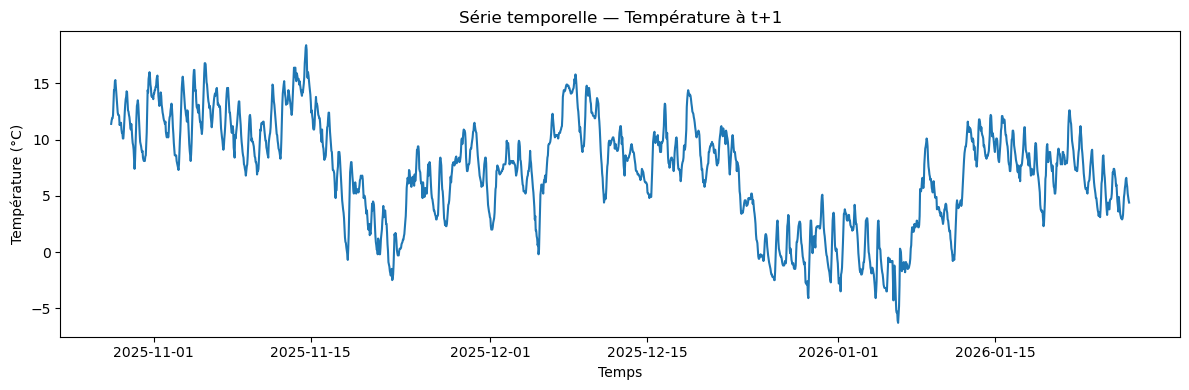

In [69]:
# Phase 5 — 2) Série temporelle cible

plt.figure(figsize=(12, 4))
plt.plot(df_features["time"], df_features["target_t_plus_1"])
plt.title("Série temporelle — Température à t+1")
plt.xlabel("Temps")
plt.ylabel("Température (°C)")
plt.tight_layout()
plt.show()


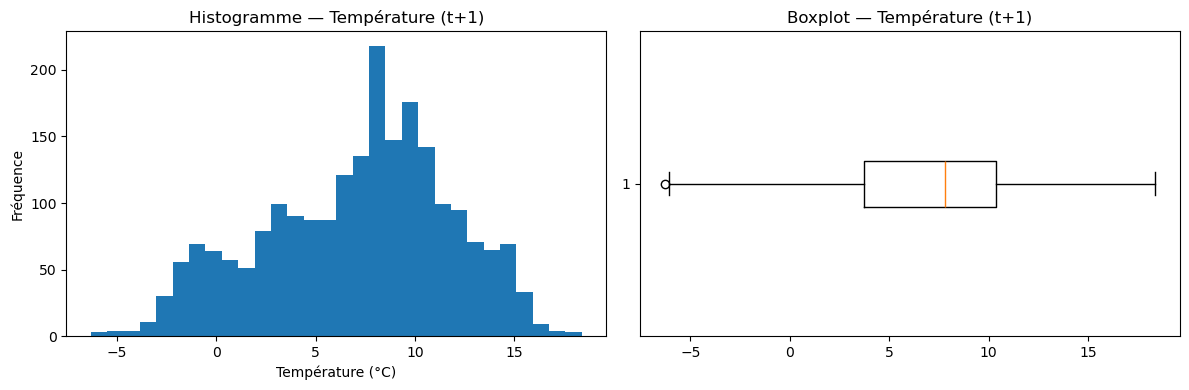

In [70]:
# Phase 5 — 3) Distribution cible

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogramme
axes[0].hist(df_features["target_t_plus_1"], bins=30)
axes[0].set_title("Histogramme — Température (t+1)")
axes[0].set_xlabel("Température (°C)")
axes[0].set_ylabel("Fréquence")

# Boxplot
axes[1].boxplot(df_features["target_t_plus_1"], vert=False)
axes[1].set_title("Boxplot — Température (t+1)")

plt.tight_layout()
plt.show()


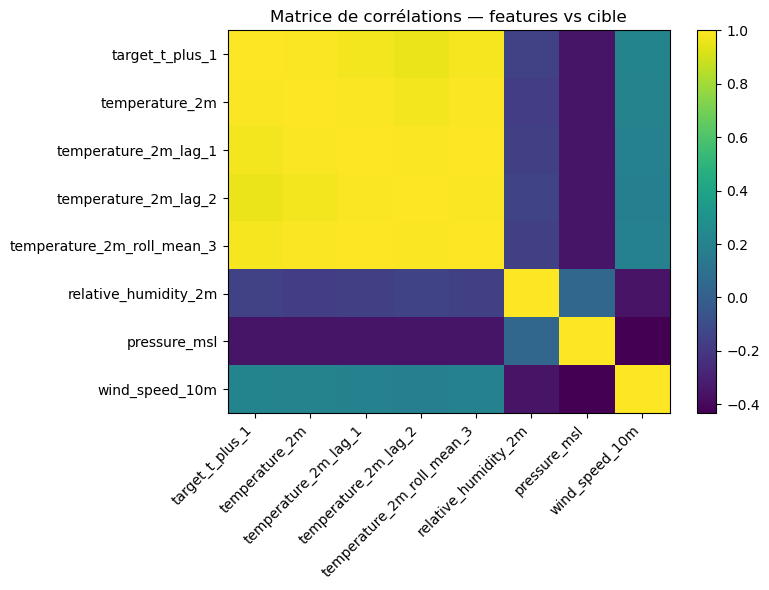

In [71]:
# Phase 5 — 4) Corrélations

# Sélection d'un sous-ensemble lisible
corr_cols = [
    "target_t_plus_1",
    "temperature_2m",
    "temperature_2m_lag_1",
    "temperature_2m_lag_2",
    "temperature_2m_roll_mean_3",
    "relative_humidity_2m",
    "pressure_msl",
    "wind_speed_10m"
]

corr_df = df_features[corr_cols].corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_df, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=45, ha="right")
plt.yticks(range(len(corr_df.index)), corr_df.index)
plt.title("Matrice de corrélations — features vs cible")
plt.tight_layout()
plt.show()


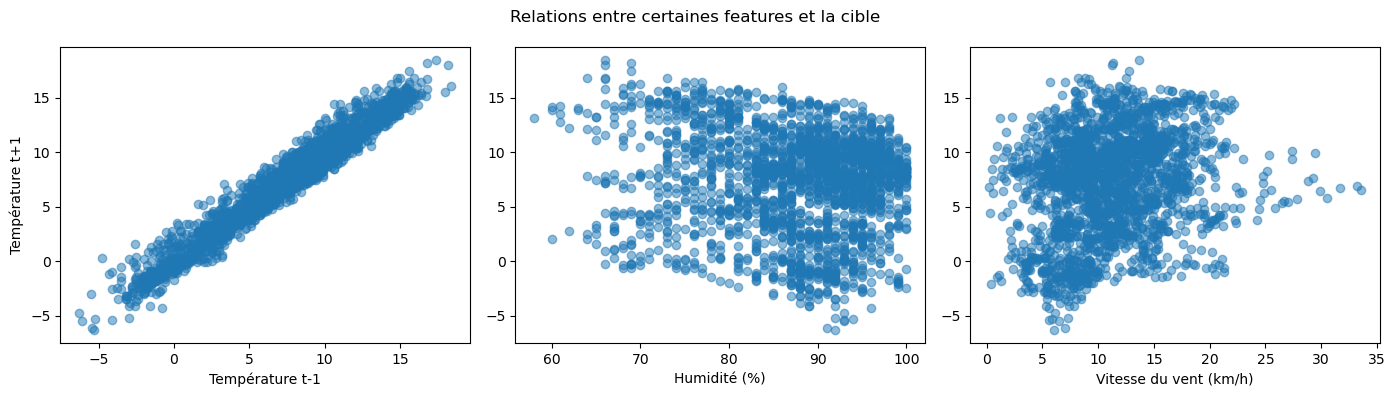

In [72]:
# Phase 5 — 5) Scatter plots

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].scatter(df_features["temperature_2m_lag_1"], df_features["target_t_plus_1"], alpha=0.5)
axes[0].set_xlabel("Température t-1")
axes[0].set_ylabel("Température t+1")

axes[1].scatter(df_features["relative_humidity_2m"], df_features["target_t_plus_1"], alpha=0.5)
axes[1].set_xlabel("Humidité (%)")

axes[2].scatter(df_features["wind_speed_10m"], df_features["target_t_plus_1"], alpha=0.5)
axes[2].set_xlabel("Vitesse du vent (km/h)")

plt.suptitle("Relations entre certaines features et la cible")
plt.tight_layout()
plt.show()


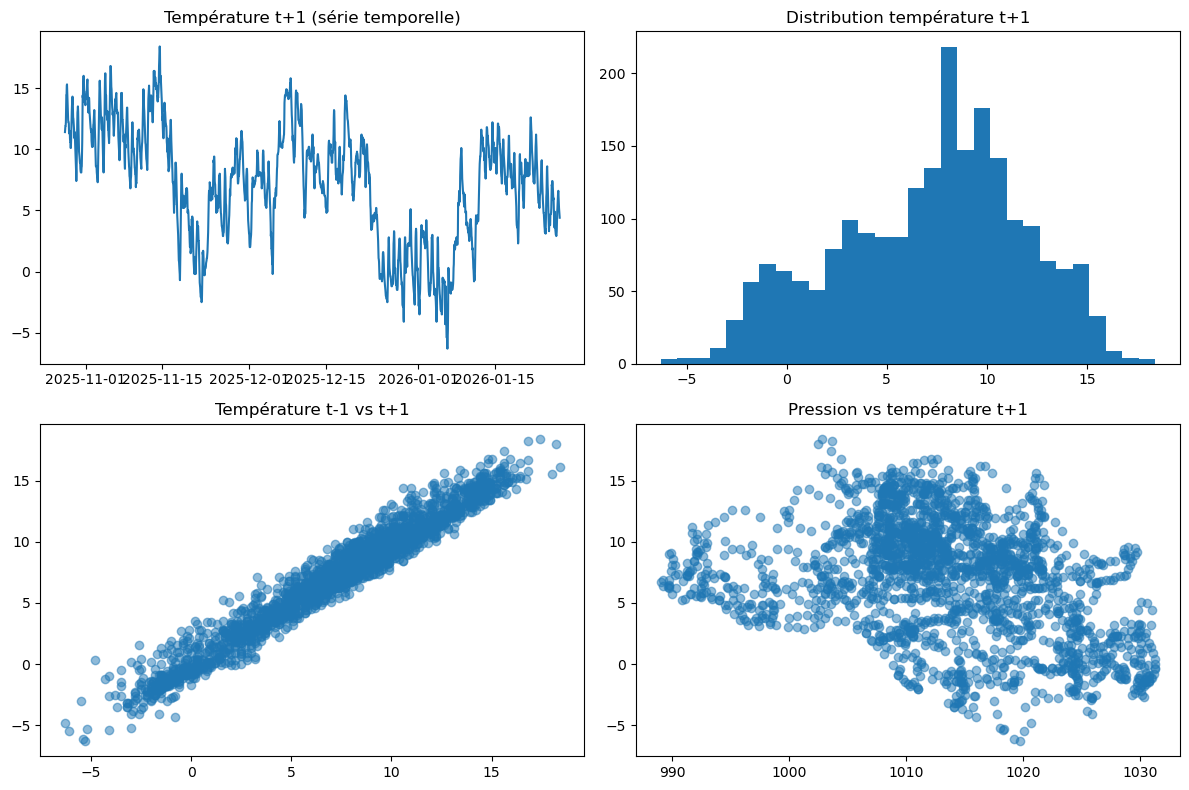

✅ Figure EDA sauvegardée : C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\reports\eda.png


In [73]:
# Phase 5 — 6) Figure de synthèse sauvegardée

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Série temporelle
axes[0, 0].plot(df_features["time"], df_features["target_t_plus_1"])
axes[0, 0].set_title("Température t+1 (série temporelle)")

# Histogramme
axes[0, 1].hist(df_features["target_t_plus_1"], bins=30)
axes[0, 1].set_title("Distribution température t+1")

# Scatter
axes[1, 0].scatter(df_features["temperature_2m_lag_1"], df_features["target_t_plus_1"], alpha=0.5)
axes[1, 0].set_title("Température t-1 vs t+1")

# Corrélation simple
axes[1, 1].scatter(df_features["pressure_msl"], df_features["target_t_plus_1"], alpha=0.5)
axes[1, 1].set_title("Pression vs température t+1")

plt.tight_layout()

eda_path = DIR_REPORTS / "eda.png"
plt.savefig(eda_path)
plt.show()

print("✅ Figure EDA sauvegardée :", eda_path)


# PHASE 6 + 7 a terminer